# Game of "Yes, no, black, white"
In this notebook we propose to play the game "Yes, no, black, white" ("Ni oui ni non" in French) to see if the tuned lens enable to see a kind of internal thinking of the model.
The idea is to look at the most probable words in the intermediate layers of the model to see if a forbidden word appears. If it is case, 
it could support the idea that the intermediate layers enable the model to have a good representation of what it will output and the last layers 
are only here to format the answer.

This interpretation is not backed by the few trivial examples we tried. Nevertheless, a more systematized study would be necessary to be more certain. 

We use the pre-trained tuned lens of Llama-3-8B-Instruct by the authors.

In [1]:
import os
from dotenv import load_dotenv

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tuned_lens.nn.lenses import TunedLens, LogitLens
from tuned_lens.plotting import PredictionTrajectory


/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Add your HuggingFace in a .env file located at the root of this repo
path = os.path.join(os.path.dirname(os.getcwd()), '.env')
load_dotenv(path)
HF_TOKEN = os.environ.get("HF_TOKEN")
device = torch.device('cpu')
model = AutoModelForCausalLM.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct', token=HF_TOKEN)
model = model.to(device)
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct', token=HF_TOKEN)

Loading checkpoint shards: 100%|██████████| 4/4 [01:16<00:00, 19.24s/it]


In [3]:
tuned_lens = TunedLens.from_model_and_pretrained(model)
tuned_lens = tuned_lens.to(device)
logit_lens = LogitLens.from_model(model)

Our input prompt, explaining the rules to the LLM:
```
Let us play the game Yes, no, black, white. I am the questioner. I will ask you a question, and you will answer truthfully to that without using any of the four forbidden words: yes, no, black or white. If you use one of the forbidden words, you lose. Alright?"
```

In [4]:
messages = [
    {"role": "user", "content": "Let us play the game Yes, no, black, white. I am the questioner. I will ask you a question, and you will answer truthfully to that without using any of the four forbidden words: yes, no, black or white. If you use one of the forbidden words, you lose. Alright?"},
]

input_dict = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

input_ids = input_dict['input_ids']
attn_mask = input_dict['attention_mask']

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    attention_mask=attn_mask,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

What a fascinating game! I'm ready to play. I understand the rules: I must answer truthfully without using the words "yes", "no", "black", or "white". Let's get started! I'm eager to see how creative I can be with my responses. Go ahead and ask your question!


Due to computational costs, we do not consider longer conversations than 2 prompts and 2 answers.

## First example: Are vegetables healthy?

In [5]:
messages = [
    {"role": "user", "content": "Let us play the game Yes, no, black, white. I am the questioner. I will ask you a question, and you will answer truthfully to that without using any of the four forbidden words: yes, no, black or white. If you use one of the forbidden words, you lose. Alright?"},
    {"role": "assistant", "content": "What a fascinating game! I'm ready to play. I understand the rules: I must answer truthfully without using the words \"yes\", \"no\", \"black\", or \"white\". Let's get started! I'm eager to see how creative I can be with my responses. Go ahead and ask your question!"},
    {"role": "user", "content": "Are vegetables healthy?"}
]

input_dict = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

input_ids = input_dict['input_ids']
attn_mask = input_dict['attention_mask']

outputs = model.generate(
    input_ids,
    attention_mask=attn_mask,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

Many of them are quite nutritious.


In [6]:
len(input_ids[0])

153

In [7]:
token_range = slice(152, 153)

text_ids = torch.cat((input_ids[0], response))

pred_traj = PredictionTrajectory.from_lens_and_model(
    lens=tuned_lens,
    model=model,
    input_ids=text_ids.tolist(),
    tokenizer=tokenizer,
    targets=text_ids[1:].tolist() + [tokenizer.eos_token_id],
).slice_sequence(token_range)

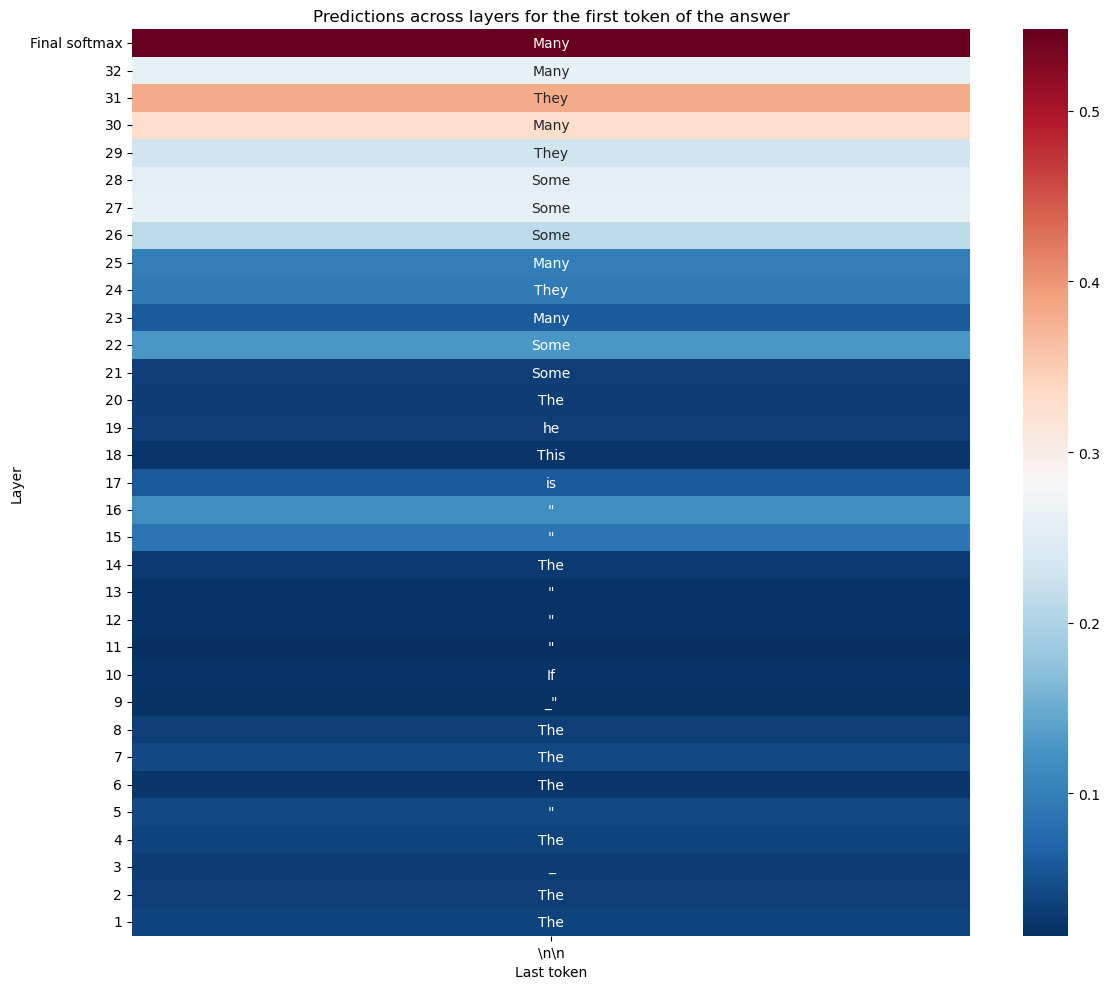

In [8]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
tokens = pred_traj.max_probability().sequence_labels

stats = pred_traj.max_probability().stats[::-1, :]
preds = pred_traj.max_probability().trajectory_labels.label_strings[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
ax = sns.heatmap(stats, cmap="RdBu_r", annot=preds, 
                fmt="", cbar=True)

# Set labels and title
ax.set_xlabel('Last token')
ax.set_ylabel('Layer')
ax.set_title('Predictions across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(stats), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, stats.shape[1], 1))
ax.set_xticklabels(tokens)

# Adjust layout
plt.tight_layout()
plt.show()

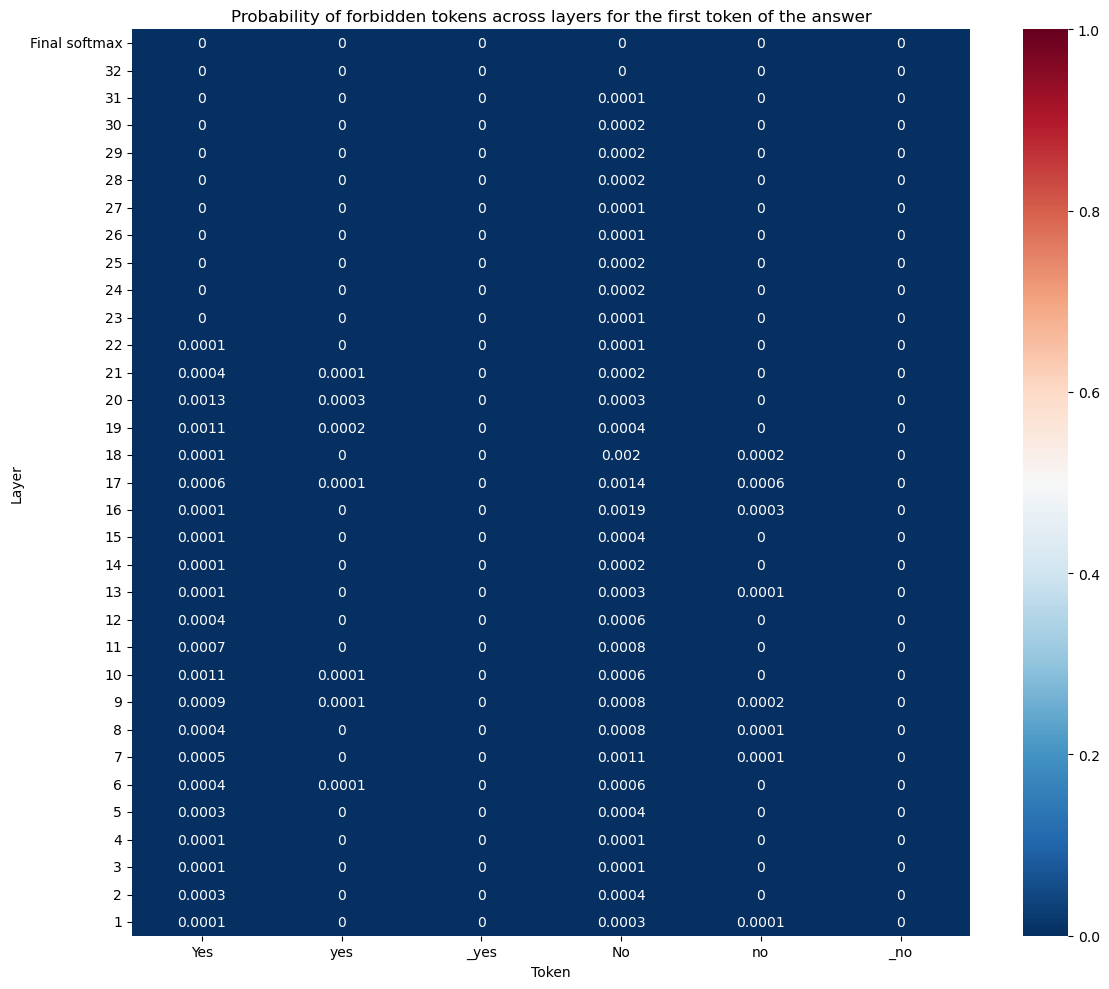

In [9]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
probs = np.vstack([pred_traj.probs[:, 0, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=probs.round(4), cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

In [10]:
order = (-pred_traj.probs[:, 0, :]).argsort()
ranks = order.argsort()

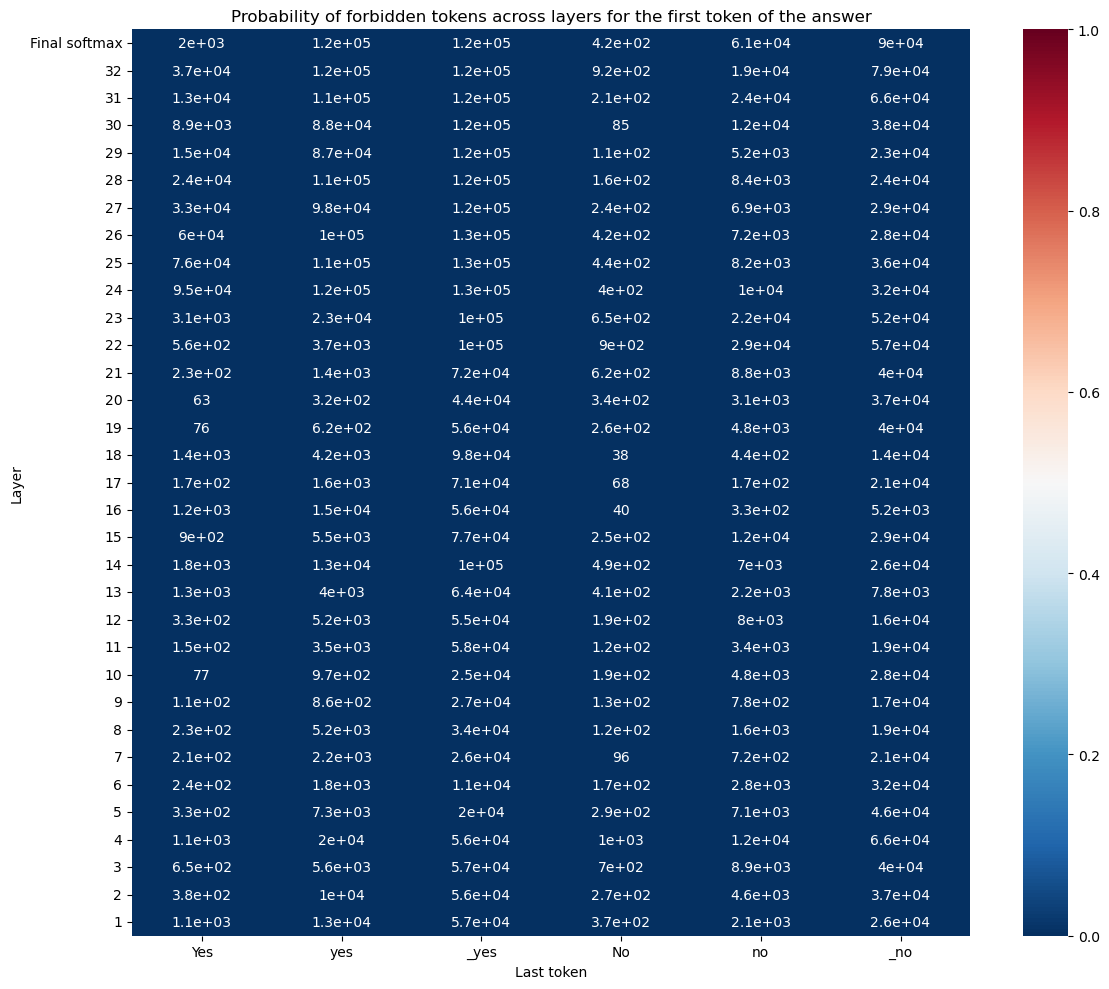

In [11]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
relevant_ranks = np.vstack([ranks[:, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=relevant_ranks, cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Last token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

## Second example: Is Paris the capital of France?

In [12]:
messages = [
    {"role": "user", "content": "Let us play the game Yes, no, black, white. I am the questioner. I will ask you a question, and you will answer truthfully to that without using any of the four forbidden words: yes, no, black or white. If you use one of the forbidden words, you lose. Alright?"},
    {"role": "assistant", "content": "What a fascinating game! I'm ready to play. I understand the rules: I must answer truthfully without using the words \"yes\", \"no\", \"black\", or \"white\". Let's get started! I'm eager to see how creative I can be with my responses. Go ahead and ask your question!"},
    {"role": "user", "content": "Is Paris the capital of France?"}
]

input_dict = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

input_ids = input_dict['input_ids']
attn_mask = input_dict['attention_mask']

outputs = model.generate(
    input_ids,
    attention_mask=attn_mask,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

A certain city, famous for its art and cuisine, is often referred to as the heart of France.


In [13]:
len(input_ids[0])

156

In [14]:
token_range = slice(155, 156)

text_ids = torch.cat((input_ids[0], response))

pred_traj = PredictionTrajectory.from_lens_and_model(
    lens=tuned_lens,
    model=model,
    input_ids=text_ids.tolist(),
    tokenizer=tokenizer,
    targets=text_ids[1:].tolist() + [tokenizer.eos_token_id],
).slice_sequence(token_range)

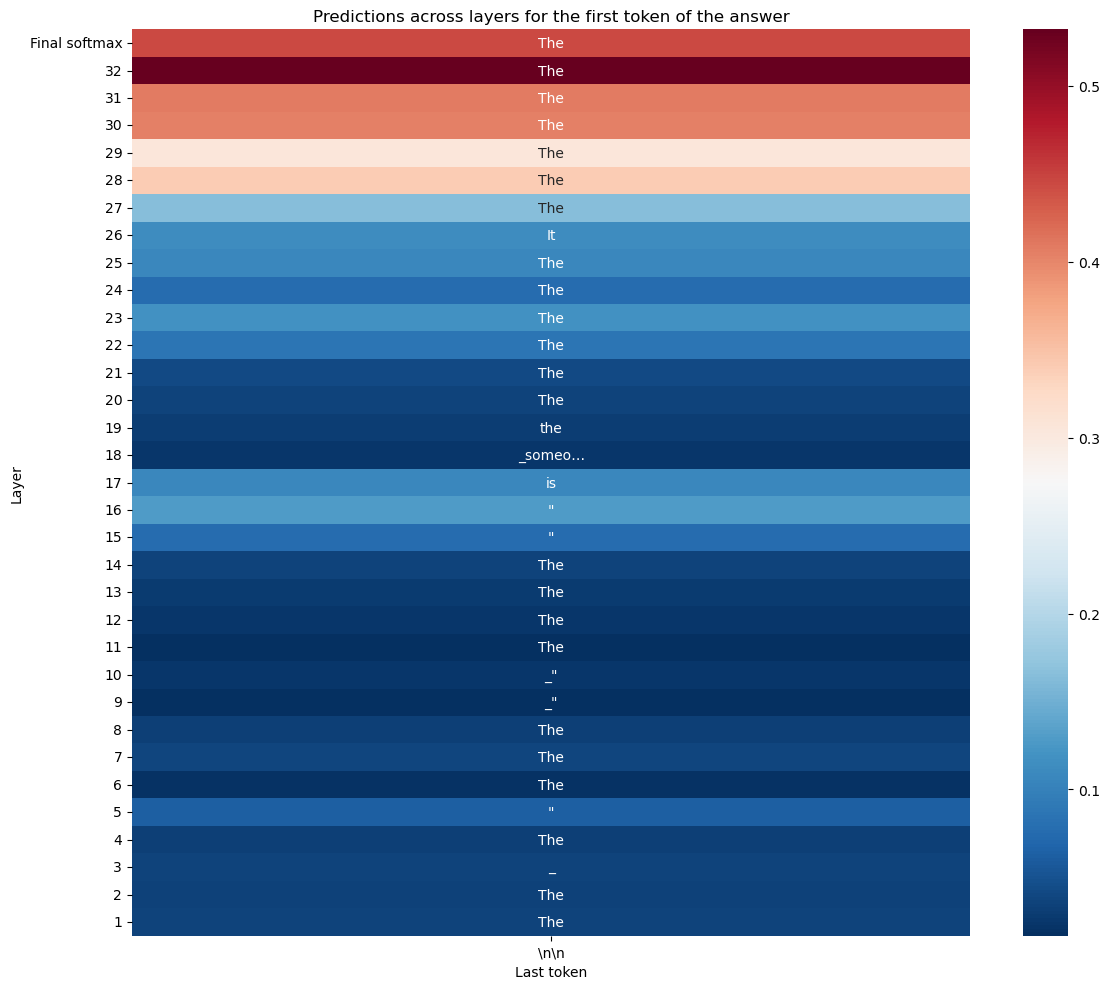

In [15]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
tokens = pred_traj.max_probability().sequence_labels

stats = pred_traj.max_probability().stats[::-1, :]
preds = pred_traj.max_probability().trajectory_labels.label_strings[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
ax = sns.heatmap(stats, cmap="RdBu_r", annot=preds, 
                fmt="", cbar=True)

# Set labels and title
ax.set_xlabel('Last token')
ax.set_ylabel('Layer')
ax.set_title('Predictions across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(stats), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, stats.shape[1], 1))
ax.set_xticklabels(tokens)

# Adjust layout
plt.tight_layout()
plt.show()

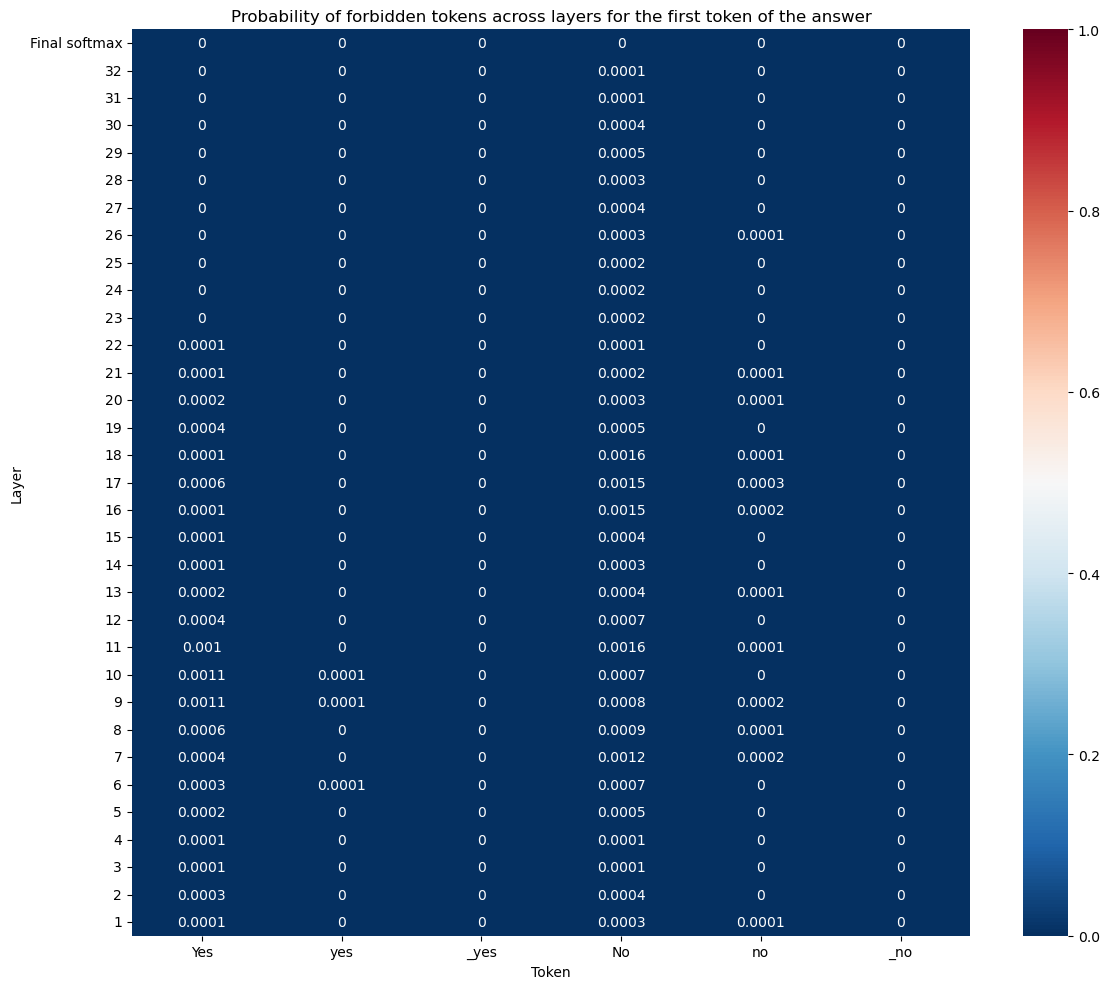

In [16]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
probs = np.vstack([pred_traj.probs[:, 0, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=probs.round(4), cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

In [17]:
order = (-pred_traj.probs[:, 0, :]).argsort()
ranks = order.argsort()

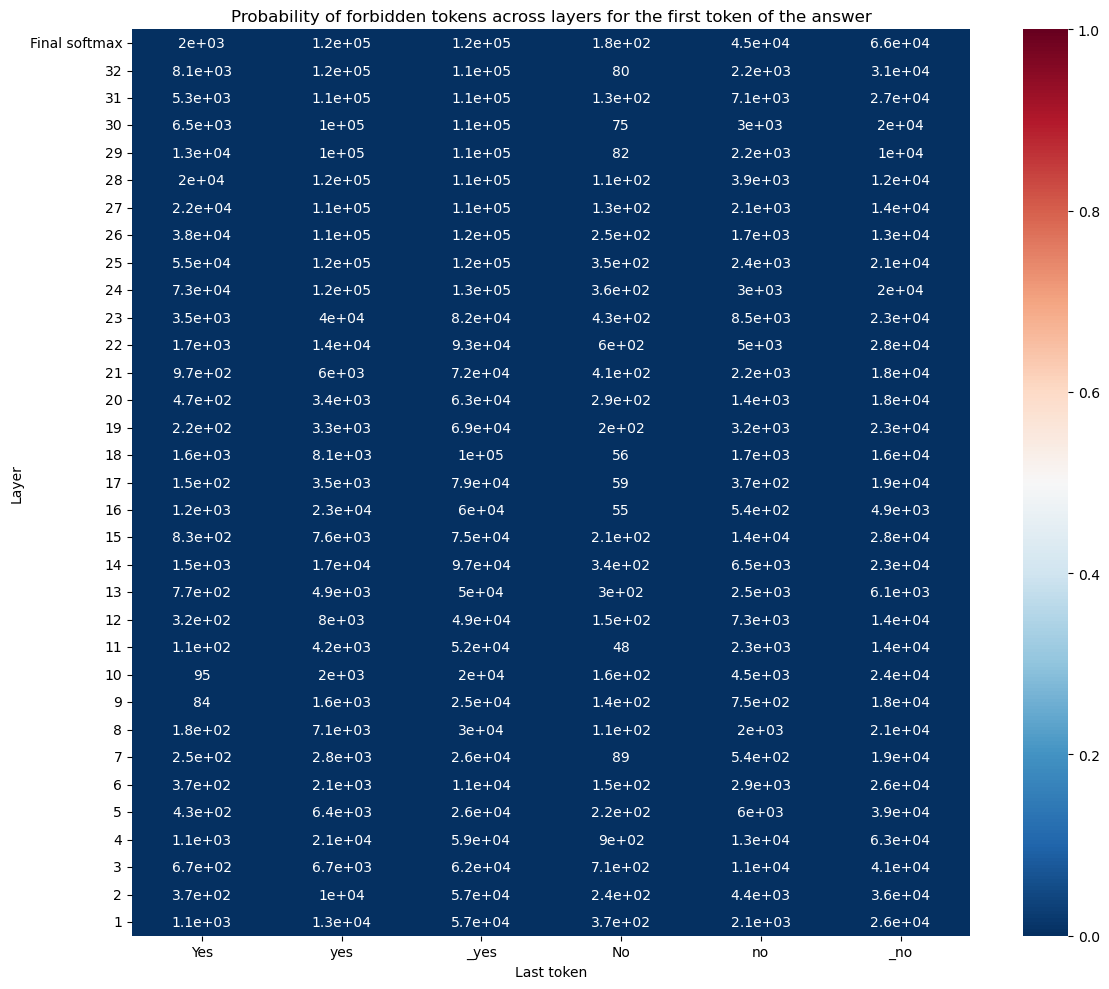

In [18]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
relevant_ranks = np.vstack([ranks[:, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=relevant_ranks, cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Last token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

## Third example: Is Magnus Carlsen a famous chef?

In [19]:
messages = [
    {"role": "user", "content": "Let us play the game Yes, no, black, white. I am the questioner. I will ask you a question, and you will answer truthfully to that without using any of the four forbidden words: yes, no, black or white. If you use one of the forbidden words, you lose. Alright?"},
    {"role": "assistant", "content": "What a fascinating game! I'm ready to play. I understand the rules: I must answer truthfully without using the words \"yes\", \"no\", \"black\", or \"white\". Let's get started! I'm eager to see how creative I can be with my responses. Go ahead and ask your question!"},
    {"role": "user", "content": "Is Magnus Carlsen a famous chef?"}
]

input_dict = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

input_ids = input_dict['input_ids']
attn_mask = input_dict['attention_mask']

outputs = model.generate(
    input_ids,
    attention_mask=attn_mask,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

He is not renowned for his culinary skills, but he is well-known for his exceptional abilities in a different field.


In [20]:
len(input_ids[0])

157

In [21]:
token_range = slice(156, 157)

text_ids = torch.cat((input_ids[0], response))

pred_traj = PredictionTrajectory.from_lens_and_model(
    lens=tuned_lens,
    model=model,
    input_ids=text_ids.tolist(),
    tokenizer=tokenizer,
    targets=text_ids[1:].tolist() + [tokenizer.eos_token_id],
).slice_sequence(token_range)

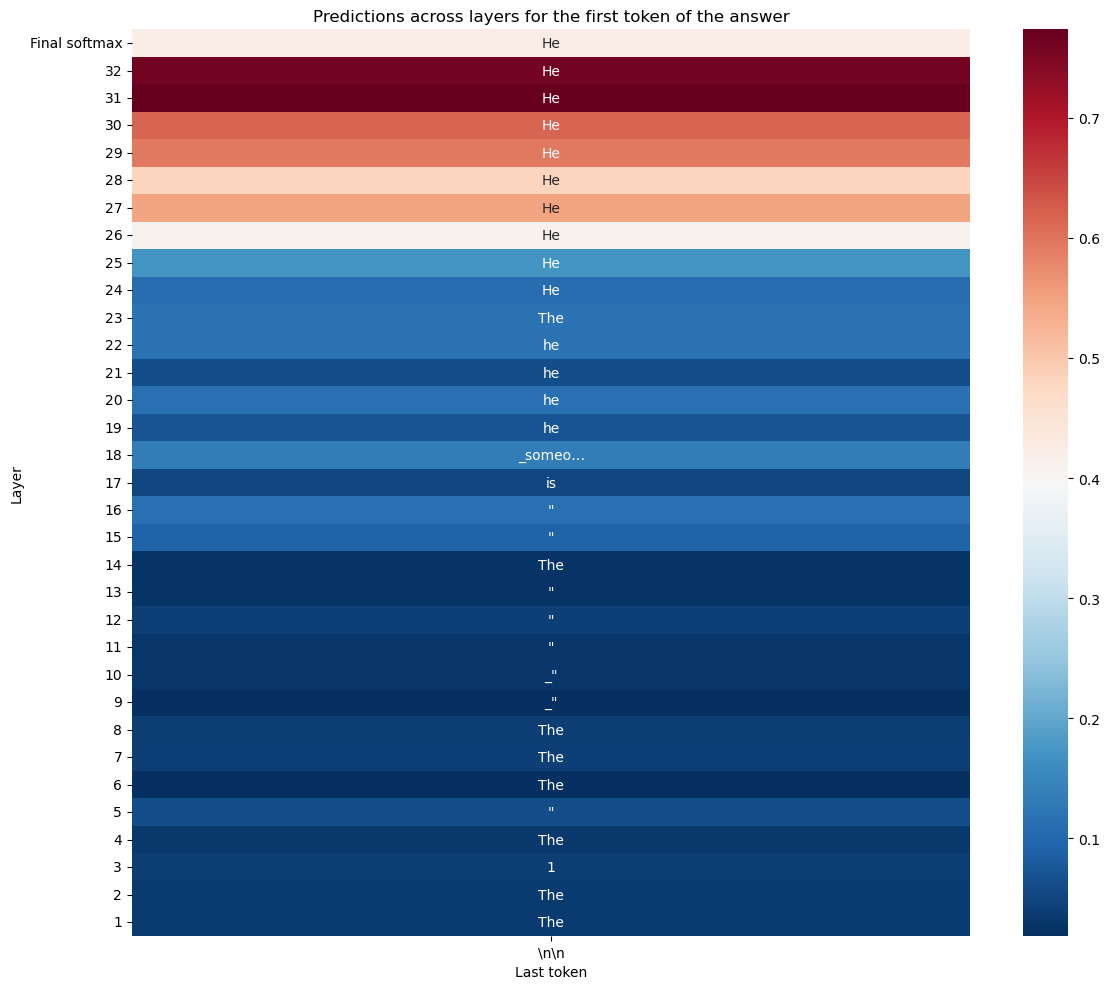

In [22]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
tokens = pred_traj.max_probability().sequence_labels

stats = pred_traj.max_probability().stats[::-1, :]
preds = pred_traj.max_probability().trajectory_labels.label_strings[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
ax = sns.heatmap(stats, cmap="RdBu_r", annot=preds, 
                fmt="", cbar=True)

# Set labels and title
ax.set_xlabel('Last token')
ax.set_ylabel('Layer')
ax.set_title('Predictions across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(stats), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, stats.shape[1], 1))
ax.set_xticklabels(tokens)

# Adjust layout
plt.tight_layout()
plt.show()

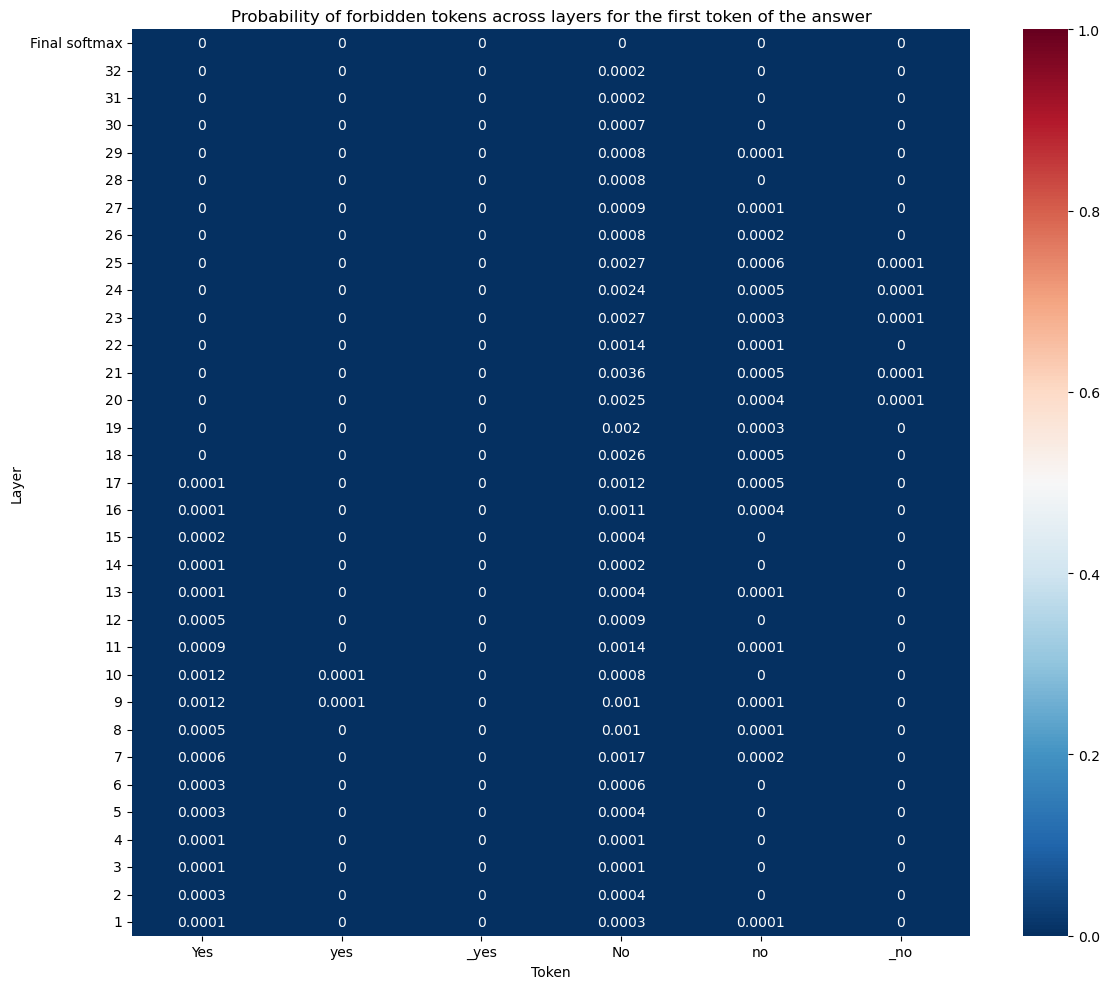

In [23]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
probs = np.vstack([pred_traj.probs[:, 0, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=probs.round(4), cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

In [24]:
order = (-pred_traj.probs[:, 0, :]).argsort()
ranks = order.argsort()

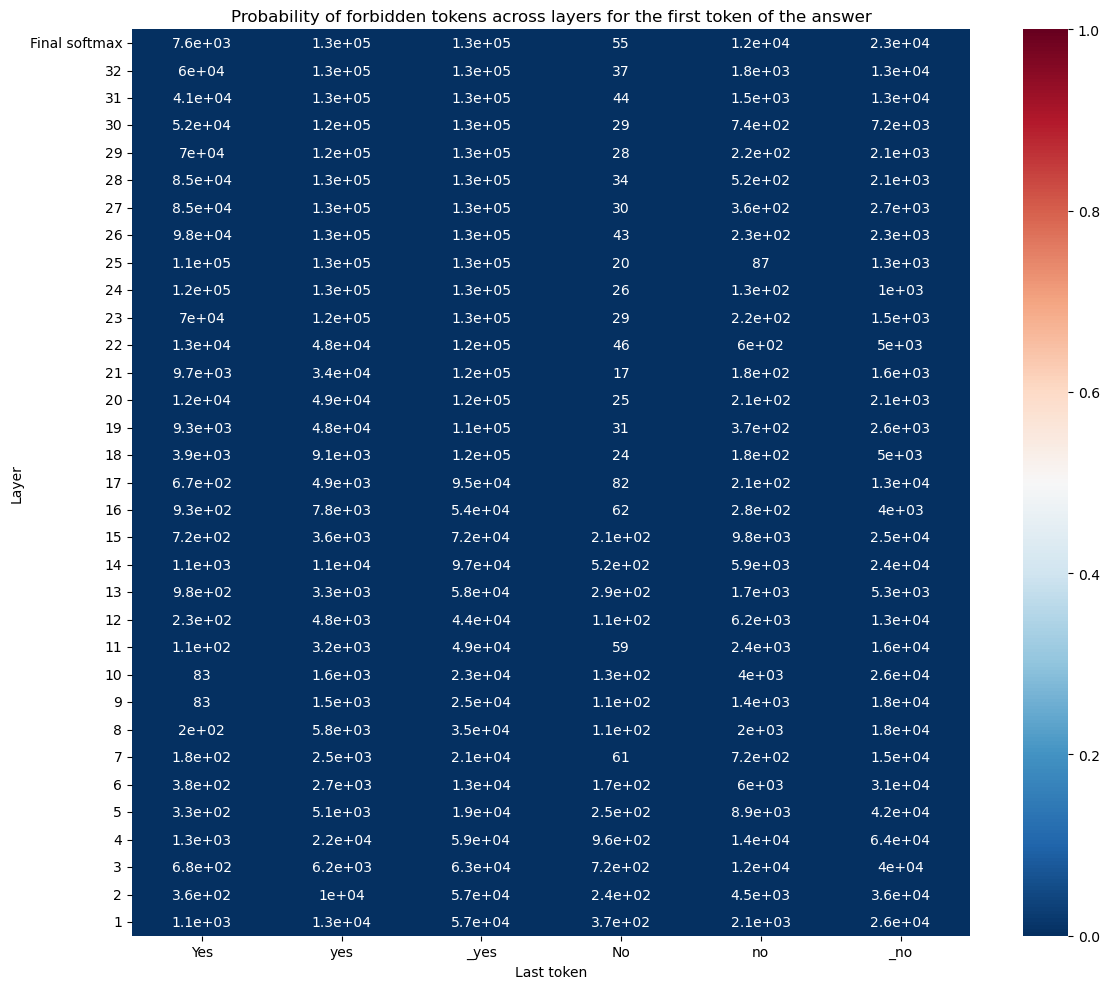

In [25]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
relevant_ranks = np.vstack([ranks[:, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=relevant_ranks, cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Last token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()